# Setup

In [1]:
import pandas as pd
import os
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
from statistics import mean
import random
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import timedelta
import pickle
import json
import timeit
import warnings
import itertools
import gc

In [2]:
sns.set_theme(style="ticks", color_codes=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Use glicko-2 implementation by Ryan Kirkman
!git clone https://github.com/ryankirkman/pyglicko2

fatal: destination path 'pyglicko2' already exists and is not an empty directory.


In [4]:
cd pyglicko2

C:\Users\igisb\Documents\GitHub\pairwise_ranking\pyglicko2


In [5]:
import glicko2

### Example 

In [90]:
# Test to see if everything's working (code from pyglicko2 repository)

def exampleCase():
    # Create a player called Ryan
    Ryan = glicko2.Player()
    print("Old Rating Deviation: " + str(Ryan.rd))
    print("Old Volatility: " + str(Ryan.vol))
    Ryan.update_player([x for x in [1400, 1550, 1700]],
        [x for x in [30, 100, 300]], [1, 0, 0])
    print("New Rating: " + str(Ryan.rating))
    print("New Rating Deviation: " + str(Ryan.rd))
    print("New Volatility: " + str(Ryan.vol))

def timingExample(runs = 10000):
    timeTaken = timeit.Timer("Ryan = glicko2.Player(); \
                             Ryan.update_player([x \
    for x in [1400, 1550, 1700]], \
    [x for x in [30, 100, 300]], [1, 0, 0])", \
        "import glicko2").repeat(1, 10000)
    print("\nThe time taken to perform " + str(runs), "separate calculations (in seconds) was:", round(timeTaken[0], 4))

In [91]:
exampleCase()
timingExample()

Old Rating Deviation: 350.0
Old Volatility: 0.06
New Rating: 1441.5327915010964
New Rating Deviation: 193.22832145690708
New Volatility: 0.05999342346059785

The time taken to perform 10000 separate calculations (in seconds) was: 0.4432


### Sample players

In [8]:
# Assume we have 1000 chess players and want to determine their ranking
# We'll need to have them play matches against each other and each match will result in a w/d/l
# Players' ranking score will change after each tournament
# I'm interested in pairwise text comparisons - so the players will be texts, and their match will be a research participant reading both texts and deciding which text is more difficult (i.e., which text wins)

# Set variables: number of players (=number of texts), and expected distribution of player strength
# s => distribution (mean: 1500, stdev: 300, n: number of players)
text_n = 1000
s = np.random.normal(1500, 300, text_n)

# Sample datapoints
# Tuple consisting of (text id, true rating, and glicko object)
objs = [(ti, tr, glicko2.Player()) for ti, tr in zip(range(text_n), s)]

## Initial simulation

In [93]:
# Simulation function
# Assume no individual differences in the participants' judgments (i.e., they will always make the 'correct' decision when gauging the difficulty of two sampled texts)
def glicko_test(text_n, s, total_participants, comparison_per_participant, stratnum):
    """
    Create 'text_n' number of texts to be evaluated from distribution 's'. 
    Set the number of participants and the number of comparisons per participant.
    Stratify texts (N=stratnum)
    """
    # Create players based on distribution 's'
    objs = [(ti, tr, glicko2.Player()) for ti, tr in zip(range(text_n), s)]

    # Define comparison number and epochs (the number of times the entire data set will be used)
    total_comparisons = total_participants * comparison_per_participant
    epochs = int(total_comparisons / text_n)
    print(f'Total comparison num: {total_comparisons}')
    print(f'Stratnum: {stratnum}')
    
    mae_iters = []
    
    # Measure time
    time_start = time.time()
    for i in range(epochs):
        # Stratification (sort by current rating and divide into different groups of set number (stratnum))
        objs_sort = sorted(objs, key=lambda x: x[2].rating)
        objs_sort = list(np.split(np.array(objs_sort), stratnum))
        # Iterate through divisions
        for play in objs_sort:
            np.random.shuffle(play)
            while len(play) != 0:
                player1 = play[0]
                player2 = play[1]
                # If player 1 (i.e., text 1) wins
                if player1[1] > player2[1]:
                    player1 = player1[2]
                    player2 = player2[2]
                    saverate = player1.rating
                    savedev = player1.rd
                    player1.update_player([player2.rating], [player2.rd], [1])
                    player2.update_player([saverate], [savedev], [0])
                # If player 2 wins
                else:
                    player1 = player1[2]
                    player2 = player2[2]
                    saverate = player2.rating
                    savedev = player2.rd
                    player2.update_player([player1.rating], [player1.rd], [1])
                    player1.update_player([saverate], [savedev], [0])
                play = play[2:]
        # check mean absolute error for each iteration
        mae_iter = mean([abs(w[1] - w[2].rating) for w in objs])
        mae_iters.append(mae_iter)
        
    time_end = time.time()

    mae = mean([abs(w[1] - w[2].rating) for w in objs])
    print(f'Mean absolute error: {mae}')
    print(f"Elapsed time: {round(time_end - time_start, 5)} seconds")
    # sns.histplot([w[2].rating for w in objs], kde=True);
    maeplt = sns.lineplot(mae_iters);
    maeplt.set(xlabel='Iteration', ylabel='Mean absolute error')
    plt.show()

    return objs

Total comparison num: 100000
Stratnum: 20
Mean absolute error: 43.15942598197506
Elapsed time: 3.26074 seconds


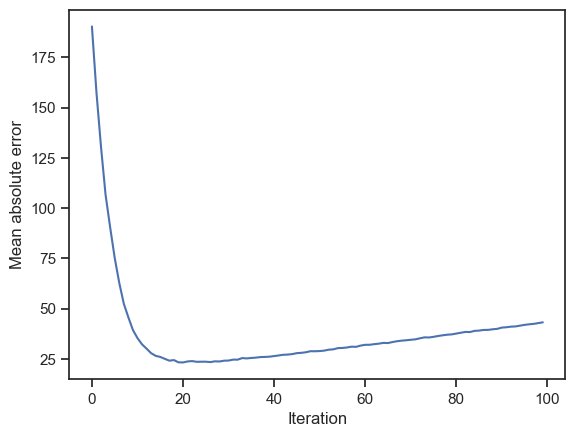

In [94]:
# Try with 20 divisions, and 1000 participants each doing 100 comparisons. Stratnum=20
glickres20 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=20)

Total comparison num: 100000
Stratnum: 100
Mean absolute error: 27.43176957514851
Elapsed time: 3.30204 seconds


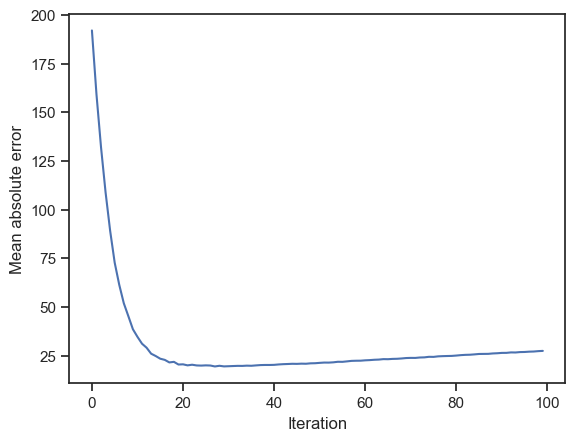

In [96]:
# Increase stratnum to 100
glickres100 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=100)

## Introduce individual differences (bias)

In [168]:
# Simulation function
def glicko_test(text_n, s, total_participants, comparison_per_participant, stratnum, inddif):
    """
    Create 'text_n' number of texts to be evaluated from distribution 's'. 
    Set the number of participants and the number of comparisons per participant.
    Stratify texts (N=stratnum)
    """
    # Create players based on distribution 's'
    objs = [(ti, tr, glicko2.Player()) for ti, tr in zip(range(text_n), s)]

    # Define comparison number and epochs (the number of times the entire data set will be used)
    total_comparisons = total_participants * comparison_per_participant
    epochs = int(total_comparisons / text_n)
    print(f'Total comparison num: {total_comparisons}')
    print(f'Stratnum: {stratnum}')
    
    mae_iters = []
    
    # Measure time
    time_start = time.time()
    for i in range(epochs):
        # Stratification (sort by current rating and divide into different groups of set number (stratnum))
        objs_sort = sorted(objs, key=lambda x: x[2].rating)
        objs_sort = list(np.split(np.array(objs_sort), stratnum))
        # Iterate through divisions
        for play in objs_sort:
            np.random.shuffle(play)
            while len(play) != 0:
                player1 = play[0]
                player2 = play[1]
                # Create individual differences for players within a set range
                p1_ind = random.uniform(-inddif, inddif)
                p2_ind = random.uniform(-inddif, inddif)
                # If player 1 (i.e., text 1) wins
                if player1[1] + p1_ind > player2[1] + p2_ind:
                    player1 = player1[2]
                    player2 = player2[2]
                    saverate = player1.rating
                    savedev = player1.rd
                    player1.update_player([player2.rating], [player2.rd], [1])
                    player2.update_player([saverate], [savedev], [0])
                # If player 2 wins
                else:
                    player1 = player1[2]
                    player2 = player2[2]
                    saverate = player2.rating
                    savedev = player2.rd
                    player2.update_player([player1.rating], [player1.rd], [1])
                    player1.update_player([saverate], [savedev], [0])
                play = play[2:]
        # check mean absolute error for each iteration
        mae_iter = mean([abs(w[1] - w[2].rating) for w in objs])
        mae_iters.append(mae_iter)
        
    time_end = time.time()

    mae = mean([abs(w[1] - w[2].rating) for w in objs])
    print(f'Mean absolute error: {mae}')
    print(f"Elapsed time: {round(time_end - time_start, 5)} seconds")
    # sns.histplot([w[2].rating for w in objs], kde=True);
    maeplt = sns.lineplot(mae_iters);
    maeplt.set(xlabel='Iteration', ylabel='Mean absolute error')
    plt.show()

    return objs

Total comparison num: 100000
Stratnum: 20
Mean absolute error: 35.999365685860376
Elapsed time: 3.34605 seconds


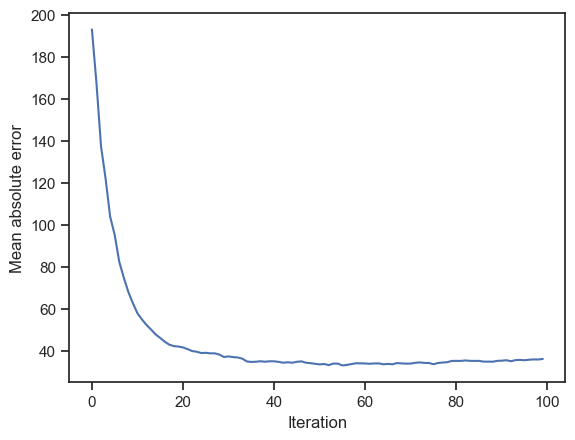

In [102]:
glickres20 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=20, inddif=150)

Total comparison num: 100000
Stratnum: 100
Mean absolute error: 33.022485882527874
Elapsed time: 3.36376 seconds


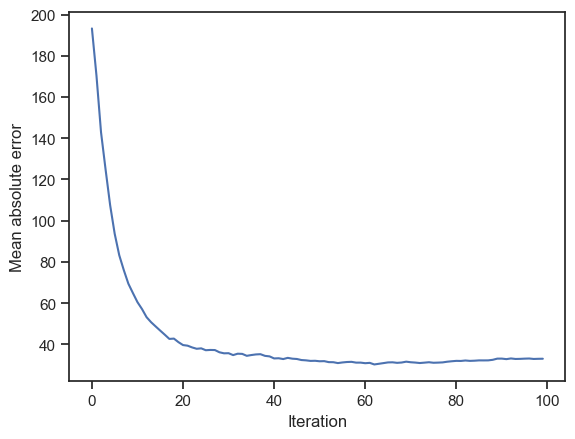

In [103]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=100, inddif=150)

Total comparison num: 100000
Stratnum: 500
Mean absolute error: 32.79864917543852
Elapsed time: 3.50268 seconds


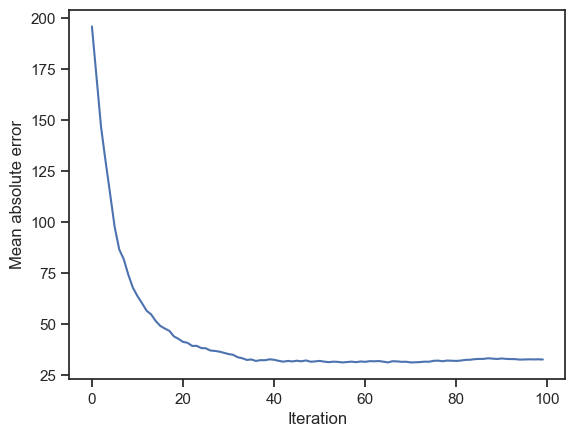

In [104]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=500, inddif=150)

## With less participants?

Total comparison num: 11000
Stratnum: 10
Mean absolute error: 62.022834103612865
Elapsed time: 0.36634 seconds


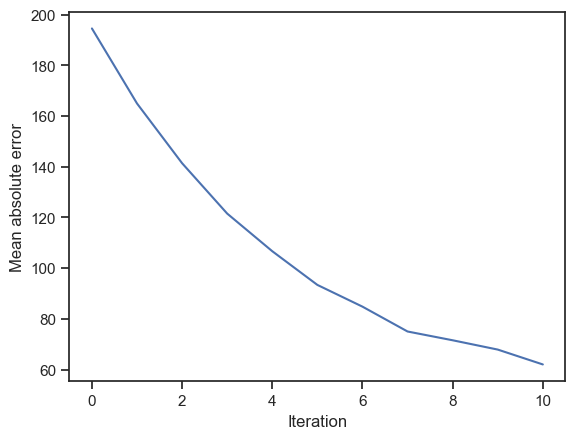

In [134]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=220, comparison_per_participant=50, stratnum=10, inddif=150)

Total comparison num: 11000
Stratnum: 100
Mean absolute error: 58.50180242472965
Elapsed time: 0.37303 seconds


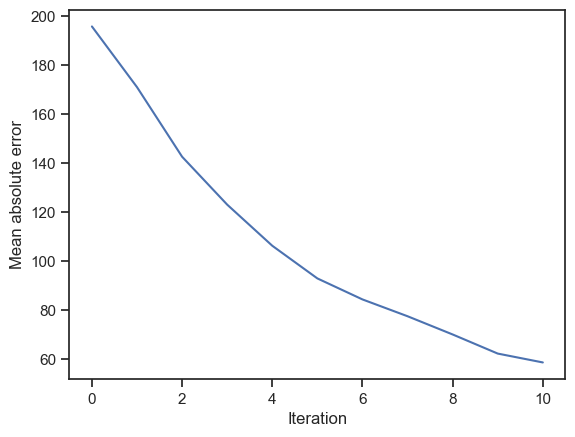

In [174]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=220, comparison_per_participant=50, stratnum=100, inddif=150)

Total comparison num: 11000
Stratnum: 500
Mean absolute error: 61.40507694577889
Elapsed time: 0.36869 seconds


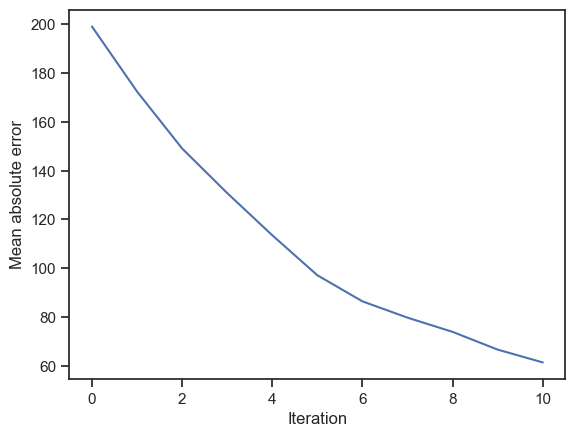

In [107]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=220, comparison_per_participant=50, stratnum=500, inddif=150)

## Introduce some pre-knowledge

In [164]:
# Simulation function
def glicko_test(text_n, s, total_participants, comparison_per_participant, stratnum, inddif, preknow):
    """
    Create 'text_n' number of texts to be evaluated from distribution 's'. 
    Set the number of participants and the number of comparisons per participant.
    Stratify texts (N=stratnum)
    Pre-knowledge (initialize ratings closer to the texts' true ratings)
    """
    # Create players based on distribution 's'
    objs = []
    for ti, tr in zip(range(text_n), s):
        cur_play = glicko2.Player()
        dif = random.uniform(-preknow, preknow)
        start_score = tr + dif
        cur_play.setRating(start_score)
        objs.append((ti, tr, cur_play))

    # Define comparison number and epochs (the number of times the entire data set will be used)
    total_comparisons = total_participants * comparison_per_participant
    epochs = int(total_comparisons / text_n)
    print(f'Total comparison num: {total_comparisons}')
    print(f'Stratnum: {stratnum}')
    
    mae_iters = []
    
    # Measure time
    time_start = time.time()
    for i in range(epochs):
        # Stratification (sort by current rating and divide into different groups of set number (stratnum))
        objs_sort = sorted(objs, key=lambda x: x[2].rating)
        objs_sort = list(np.split(np.array(objs_sort), stratnum))
        # Iterate through divisions
        for play in objs_sort:
            np.random.shuffle(play)
            while len(play) != 0:
                player1 = play[0]
                player2 = play[1]
                # Create individual differences for players within a set range
                p1_ind = random.uniform(-inddif, inddif)
                p2_ind = random.uniform(-inddif, inddif)
                # If player 1 (i.e., text 1) wins
                if player1[1] + p1_ind > player2[1] + p2_ind:
                    player1 = player1[2]
                    player2 = player2[2]
                    saverate = player1.rating
                    savedev = player1.rd
                    player1.update_player([player2.rating], [player2.rd], [1])
                    player2.update_player([saverate], [savedev], [0])
                # If player 2 wins
                else:
                    player1 = player1[2]
                    player2 = player2[2]
                    saverate = player2.rating
                    savedev = player2.rd
                    player2.update_player([player1.rating], [player1.rd], [1])
                    player1.update_player([saverate], [savedev], [0])
                play = play[2:]
        # check mean absolute error for each iteration
        mae_iter = mean([abs(w[1] - w[2].rating) for w in objs])
        mae_iters.append(mae_iter)
        
    time_end = time.time()

    mae = mean([abs(w[1] - w[2].rating) for w in objs])
    print(f'Mean absolute error: {mae}')
    print(f"Elapsed time: {round(time_end - time_start, 5)} seconds")
    # sns.histplot([w[2].rating for w in objs], kde=True);
    maeplt = sns.lineplot(mae_iters);
    maeplt.set(xlabel='Iteration', ylabel='Mean absolute error')
    plt.show()

    return objs

Total comparison num: 100000
Stratnum: 100
Mean absolute error: 115.95196088583134
Elapsed time: 3.53044 seconds


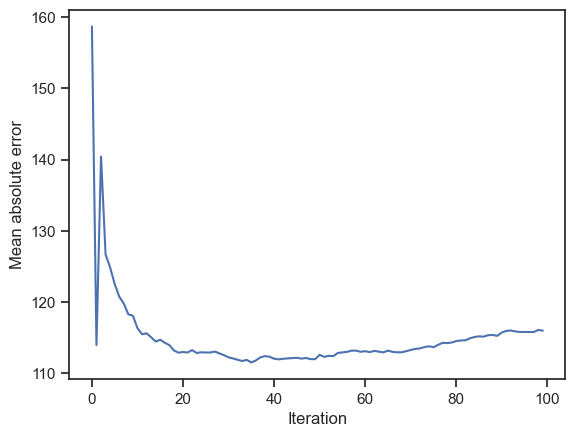

In [165]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=100, inddif=200, preknow=50)

Total comparison num: 100000
Stratnum: 500
Mean absolute error: 117.30545949387815
Elapsed time: 3.6976 seconds


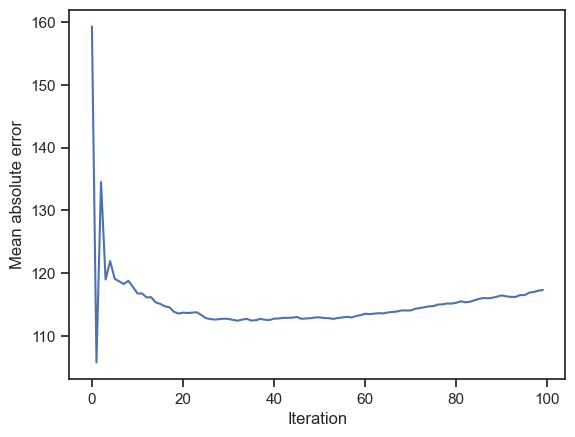

In [166]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=500, inddif=200, preknow=50)

In [177]:
# Simulation function
def glicko_test(text_n, s, total_participants, comparison_per_participant, stratnum, inddif, preknow, preknow_score):
    """
    Create 'text_n' number of texts to be evaluated from distribution 's'. 
    Set the number of participants and the number of comparisons per participant.
    Stratify texts (N=stratnum)
    Pre-knowledge - initialize ratings closer to the texts' true ratings by dividng texts into different difficulty brackets.
    """
    # Create players based on distribution 's'
    objs = [(ti, tr, glicko2.Player()) for ti, tr in zip(range(text_n), s)]
    objs_sort = sorted(objs, key=lambda x: x[1])
    objs_sort = list(np.split(np.array(objs_sort), preknow))
    for obj_brack, pst in zip(objs_sort, preknow_score):
        for obj in obj_brack:
            obj[2].setRating(pst)

    # Define comparison number and epochs (the number of times the entire data set will be used)
    total_comparisons = total_participants * comparison_per_participant
    epochs = int(total_comparisons / text_n)
    print(f'Total comparison num: {total_comparisons}')
    print(f'Stratnum: {stratnum}')
    
    mae_iters = []
    
    # Measure time
    time_start = time.time()
    for i in range(epochs):
        # Stratification (sort by current rating and divide into different groups of set number (stratnum))
        objs_sort = sorted(objs, key=lambda x: x[2].rating)
        objs_sort = list(np.split(np.array(objs_sort), stratnum))
        # Iterate through divisions
        for play in objs_sort:
            np.random.shuffle(play)
            while len(play) != 0:
                player1 = play[0]
                player2 = play[1]
                # Create individual differences for players within a set range
                p1_ind = random.uniform(-inddif, inddif)
                p2_ind = random.uniform(-inddif, inddif)
                # If player 1 (i.e., text 1) wins
                if player1[1] + p1_ind > player2[1] + p2_ind:
                    player1 = player1[2]
                    player2 = player2[2]
                    saverate = player1.rating
                    savedev = player1.rd
                    player1.update_player([player2.rating], [player2.rd], [1])
                    player2.update_player([saverate], [savedev], [0])
                # If player 2 wins
                else:
                    player1 = player1[2]
                    player2 = player2[2]
                    saverate = player2.rating
                    savedev = player2.rd
                    player2.update_player([player1.rating], [player1.rd], [1])
                    player1.update_player([saverate], [savedev], [0])
                play = play[2:]
        # check mean absolute error for each iteration
        mae_iter = mean([abs(w[1] - w[2].rating) for w in objs])
        mae_iters.append(mae_iter)
        
    time_end = time.time()

    mae = mean([abs(w[1] - w[2].rating) for w in objs])
    print(f'Mean absolute error: {mae}')
    print(f"Elapsed time: {round(time_end - time_start, 5)} seconds")
    # sns.histplot([w[2].rating for w in objs], kde=True);
    maeplt = sns.lineplot(mae_iters);
    maeplt.set(xlabel='Iteration', ylabel='Mean absolute error')
    plt.show()

    return objs

Total comparison num: 100000
Stratnum: 100
Mean absolute error: 83.9160238759747
Elapsed time: 3.39712 seconds


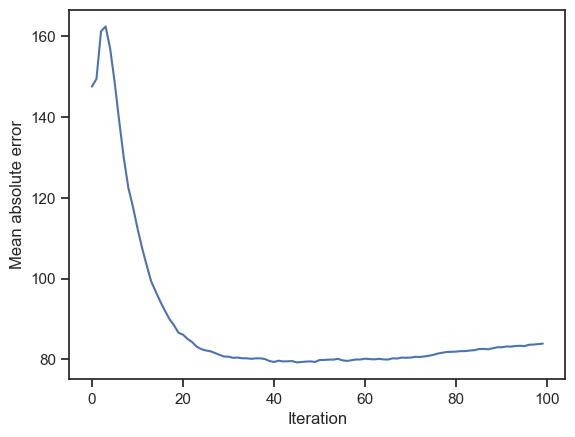

In [143]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=100, inddif=150, preknow=4, preknow_score=[1200, 1400, 1600, 1800])

Total comparison num: 100000
Stratnum: 100
Mean absolute error: 66.35625116284645
Elapsed time: 3.32864 seconds


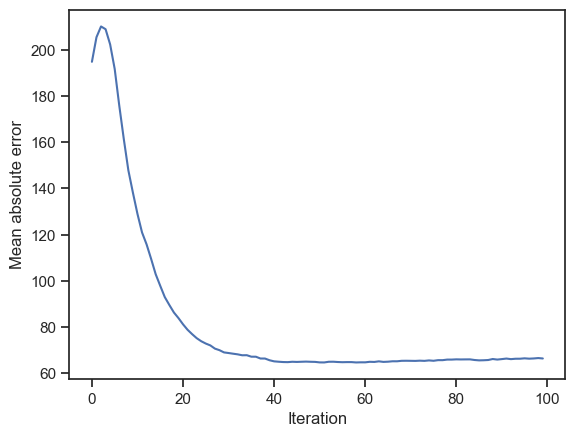

In [163]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=100, inddif=150, preknow=4, preknow_score=[1400, 1500, 1600, 1700])

Total comparison num: 100000
Stratnum: 100
Mean absolute error: 119.77900974223854
Elapsed time: 3.40415 seconds


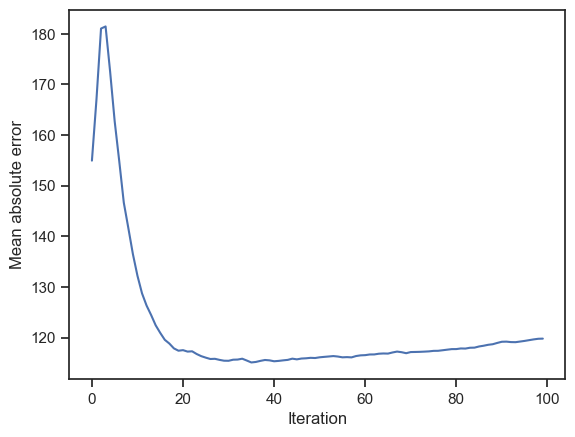

In [179]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=200, inddif=150, preknow=10, preknow_score=[1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])

Total comparison num: 100000
Stratnum: 50
Mean absolute error: 122.50893928197854
Elapsed time: 3.39441 seconds


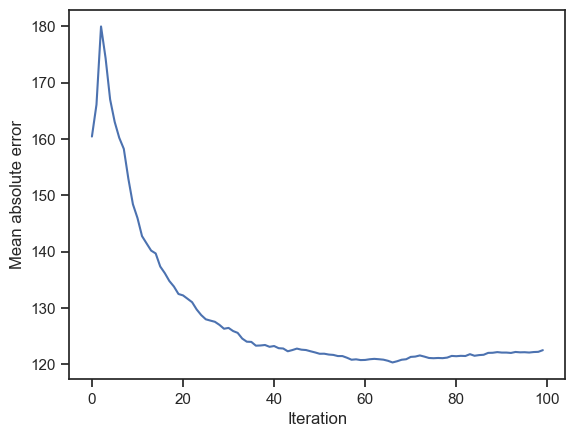

In [ ]:
glickres100 = glicko_test(text_n=1000, s=s, total_participants=1000, comparison_per_participant=100, stratnum=50, inddif=150, preknow=10, preknow_score=[1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])

## Grid search with different scenarios